In [1]:
# ------------------------------------------------------
# System dependencies (Box2D) for Google Colab on Linux
# ------------------------------------------------------
!apt-get update -qq
!apt-get install -y -qq swig

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package swig4.0.
(Reading database ... 121852 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubuntu1_all.deb ...
Unpacking swig (4.0.2-1ubuntu1) ...
Setting up swig4.0 (4.0.2-1ubuntu1) ...
Setting up swig (4.0.2-1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...


In [2]:
# ------------------------------------------------------
# Python packages
# ------------------------------------------------------
!pip install -q gymnasium gymnasium[box2d] stable-baselines3 pygame imageio matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 21.8 MB/s eta 0:00:00


Using cuda device
Logging to ./ppo_logs/PPO_1


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 223      |
|    ep_rew_mean     | -109     |
| time/              |          |
|    fps             | 5597     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 16384    |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 334           |
|    ep_rew_mean          | -112          |
| time/                   |               |
|    fps                  | 3104          |
|    iterations           | 2             |
|    time_elapsed         | 10            |
|    total_timesteps      | 32768         |
| train/                  |               |
|    approx_kl            | 0.0059193326  |
|    clip_fraction        | 0.0517        |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.73         |
|    explained_variance   | 0.00030231476 |


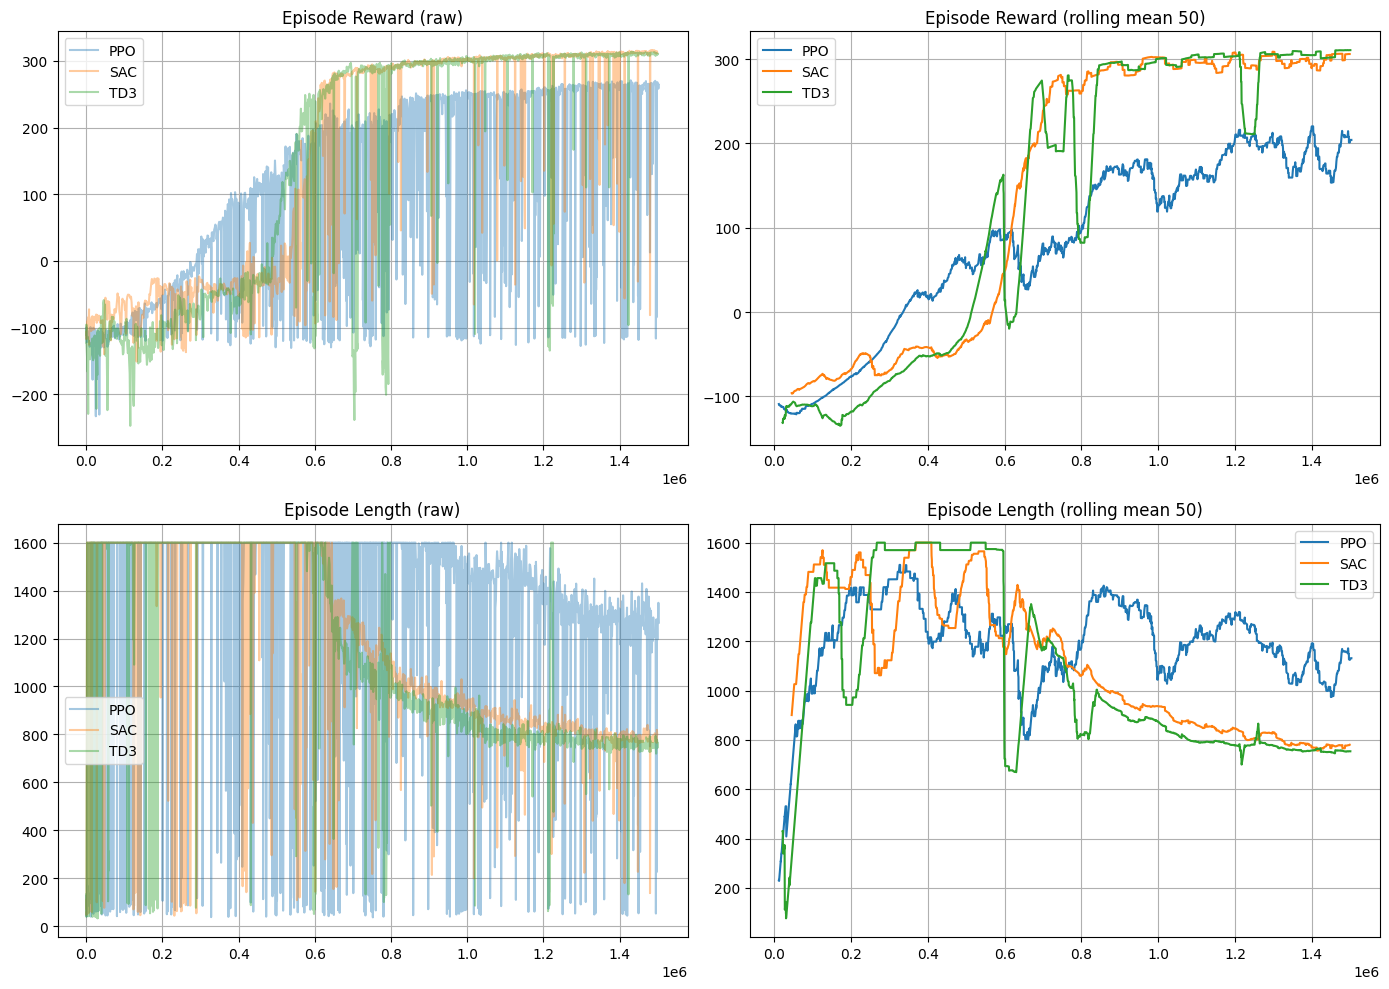

✅ PNG saved: bipedalwalker_algorithms_comparison.png
✅ GIFs saved: PPO / SAC / TD3


In [ ]:
# ------------------------------------------------------
# Imports
# ------------------------------------------------------
import gymnasium as gym
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd

from stable_baselines3 import PPO, SAC, TD3
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results
from stable_baselines3.common.noise import NormalActionNoise

# ------------------------------------------------------
# Environment
# ------------------------------------------------------
ENV_NAME = "BipedalWalker-v3"    # Continuous control environment
TOTAL_TIMESTEPS = 1_500_000      # Total training steps for each algorithm

# ======================================================
# PPO
# ======================================================
ppo_log_dir = "./ppo_logs/"      # Directory to store PPO logs

# Create vectorized environment (8 parallel environments)
ppo_env = make_vec_env(
    ENV_NAME,
    n_envs=8,
    seed=0,
    monitor_dir=ppo_log_dir      # Monitor records episode stats
)

# PPO model initialization
ppo_model = PPO(
    "MlpPolicy",                 # Fully connected neural network policy
    ppo_env,
    learning_rate=3e-4,
    n_steps=2048,                # Rollout size before update
    batch_size=64,
    n_epochs=10,                 # Optimization epochs per update
    gamma=0.99,                  # Discount factor
    gae_lambda=0.95,             # GAE parameter
    clip_range=0.2,              # PPO clipping parameter
    ent_coef=0.01,               # Entropy bonus (encourages exploration)
    verbose=1,
    tensorboard_log=ppo_log_dir
)

# Train PPO
ppo_model.learn(total_timesteps=TOTAL_TIMESTEPS)

# ======================================================
# SAC
# ======================================================
sac_log_dir = "./sac_logs/"      # Directory to store SAC logs

# Create vectorized environment (4 parallel environments)
sac_env = make_vec_env(
    ENV_NAME,
    n_envs=4,
    seed=0,
    monitor_dir=sac_log_dir
)

# SAC model initialization
sac_model = SAC(
    "MlpPolicy",
    sac_env,
    learning_rate=3e-4,
    buffer_size=1_000_000,       # Replay buffer size
    batch_size=256,
    gamma=0.99,
    tau=0.005,                   # Target network soft update coefficient
    ent_coef="auto",             # Automatic entropy tuning
    verbose=1,
    tensorboard_log=sac_log_dir
)

# Train SAC
sac_model.learn(total_timesteps=TOTAL_TIMESTEPS)

# ======================================================
# TD3
# ======================================================
td3_log_dir = "./td3_logs/"      # Directory to store TD3 logs

# Single environment
td3_env = make_vec_env(
    ENV_NAME,
    n_envs=1,
    seed=0,
    monitor_dir=td3_log_dir
)

# Action noise for exploration (Gaussian noise)
n_actions = td3_env.action_space.shape[-1]
action_noise = NormalActionNoise(
    mean=np.zeros(n_actions),
    sigma=0.2 * np.ones(n_actions)
)

td3_model = TD3(
    "MlpPolicy",
    td3_env,
    learning_rate=3e-4,
    buffer_size=1_000_000,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    action_noise=action_noise,   # Exploration noise
    policy_delay=2,              # Delayed policy updates
    target_policy_noise=0.2,     # Target smoothing noise
    target_noise_clip=0.5,       # Noise clipping
    verbose=1,
    tensorboard_log=td3_log_dir
)

# Train TD3
td3_model.learn(total_timesteps=TOTAL_TIMESTEPS)

# ======================================================
# Load monitor data
# ======================================================
def rolling_mean(y, window=50):
    """Compute rolling average to smooth curves."""
    return pd.Series(y).rolling(window).mean()

def load_reward_curve(log_dir):
    """Load episode rewards and compute cumulative timesteps."""
    df = load_results(log_dir)
    x = np.cumsum(df["l"].values)  # Cumulative episode lengths → total timesteps
    y = df["r"].values             # Episode rewards
    return x, y

def load_length_curve(log_dir):
    """Load episode lengths and compute cumulative timesteps."""
    df = load_results(log_dir)
    x = np.cumsum(df["l"].values)
    y = df["l"].values             # Episode lengths
    return x, y

# ======================================================
# PLOTS — comparison
# ======================================================
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# -------- Reward (raw) --------
x, y = load_reward_curve(ppo_log_dir)
axs[0, 0].plot(x, y, alpha=0.4, label="PPO")

x, y = load_reward_curve(sac_log_dir)
axs[0, 0].plot(x, y, alpha=0.4, label="SAC")

x, y = load_reward_curve(td3_log_dir)
axs[0, 0].plot(x, y, alpha=0.4, label="TD3")

axs[0, 0].set_title("Episode Reward (raw)")
axs[0, 0].legend()
axs[0, 0].grid(True)

# -------- Reward (smoothed) --------
x, y = load_reward_curve(ppo_log_dir)
axs[0, 1].plot(x, rolling_mean(y), label="PPO")

x, y = load_reward_curve(sac_log_dir)
axs[0, 1].plot(x, rolling_mean(y), label="SAC")

x, y = load_reward_curve(td3_log_dir)
axs[0, 1].plot(x, rolling_mean(y), label="TD3")

axs[0, 1].set_title("Episode Reward (rolling mean 50)")
axs[0, 1].legend()
axs[0, 1].grid(True)

# -------- Episode length (raw) --------
x, y = load_length_curve(ppo_log_dir)
axs[1, 0].plot(x, y, alpha=0.4, label="PPO")

x, y = load_length_curve(sac_log_dir)
axs[1, 0].plot(x, y, alpha=0.4, label="SAC")

x, y = load_length_curve(td3_log_dir)
axs[1, 0].plot(x, y, alpha=0.4, label="TD3")

axs[1, 0].set_title("Episode Length (raw)")
axs[1, 0].legend()
axs[1, 0].grid(True)

# -------- Episode length (smoothed) --------
x, y = load_length_curve(ppo_log_dir)
axs[1, 1].plot(x, rolling_mean(y), label="PPO")

x, y = load_length_curve(sac_log_dir)
axs[1, 1].plot(x, rolling_mean(y), label="SAC")

x, y = load_length_curve(td3_log_dir)
axs[1, 1].plot(x, rolling_mean(y), label="TD3")

axs[1, 1].set_title("Episode Length (rolling mean 50)")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig("bipedalwalker_algorithms_comparison.png", dpi=300)
plt.show()

# ======================================================
# Save GIFs
# ======================================================
def save_gif(model, filename):
    env = gym.make(ENV_NAME, render_mode="rgb_array")
    obs, _ = env.reset()
    frames = []

    for _ in range(1200):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            obs, _ = env.reset()

    env.close()
    imageio.mimsave(filename, frames, fps=30)

# Generate GIFs for each trained agent
save_gif(ppo_model, "bipedalwalker_ppo.gif")
save_gif(sac_model, "bipedalwalker_sac.gif")
save_gif(td3_model, "bipedalwalker_td3.gif")

print("✅ PNG saved: bipedalwalker_algorithms_comparison.png")
print("✅ GIFs saved: PPO / SAC / TD3")